# Phaeocystis pathway analysis
In this notebook, we'll analyze the pathways expressed by Phaeocystis globosa. Specifically, we're interested in cyclic patterns, carbohydrate production, etc. 
First we'll extract transcripts annotated to Phaeocystis globosa, combine them with functional information, gene expression info and metadata.

In [145]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np

## Data preparation

In [6]:
# Read transcripts annotated to Phaeocystis (from the output of the mtx_taxonomy.ipynb script)
phaeocystis_transcripts = pd.read_csv("../data/annotation/taxonomy_eukprot/130/genus_bins/Phaeocystis_transcriptome_bin.csv")
print(len(phaeocystis_transcripts))
# Filter out transcripts annotated to Phaeocystis globosa with a percent identity above 80
phaeocystis_transcripts = phaeocystis_transcripts[(phaeocystis_transcripts["p_ident"] > 0.8) & (phaeocystis_transcripts["Name_to_Use"] == "Phaeocystis globosa")]
print(len(phaeocystis_transcripts))

# Keep only the transcript IDs
phaeocystis_transcripts = phaeocystis_transcripts["query_id"].tolist()

256074
76296


In [11]:
# Read in the functional annotation data
functional_annotation = pd.read_table('../data/annotation/functional/130/functional_annotation.emapper.annotations', )
# Cut off weird characters from the transcript names
functional_annotation['#query'] = functional_annotation['#query'].str.split(".", n=1, expand=True)[0]
# Rename the query_id column
functional_annotation.rename(columns={'#query': 'transcript_id'}, inplace=True)
print(len(functional_annotation))
# Only keep the rows that are in the Phaeocystis transcriptome
functional_annotation = functional_annotation[functional_annotation['transcript_id'].isin(phaeocystis_transcripts)]
print(len(functional_annotation))

471141
48879


In [22]:
# Read in the quantification data
tpl = pd.read_csv('../data/quantification/130_tpl.csv')

# Rename the target_id column
tpl.rename(columns={'target_id': 'transcript_id'}, inplace=True)

# Change into long format
tpl = tpl.melt(id_vars=['transcript_id'], var_name='sample', value_name='TPL')

# Only keep the rows that are in the Phaeocystis transcriptome
tpl = tpl[tpl['transcript_id'].isin(phaeocystis_transcripts)]

## Generate Phaeocystis TPL sums per sample
phaeo_tpl_sums = tpl.groupby('sample')['TPL'].sum().reset_index()

## Rename columns
phaeo_tpl_sums.columns = ['sample', 'Phaeocystis_total_TPL']

In [27]:
# Read in the environmental data
env_data = pd.read_csv('../data/samples_env.csv', index_col=0)
# Read in primary production data
PP_data = pd.read_csv('../data/raw/LabSTAF/labstaf_combined_data.csv')
## Combine Station and Sample columns into one station_sample column
PP_data['Station'] = PP_data['Station'].astype(str) + '_' + PP_data['Sample'].astype(str)


# Merge PP_data with env and transcript data
env_data = env_data.merge(PP_data[['Station', 'PP']], on=['Station'], how='inner')

# Rename station column
env_data.rename(columns={'Station': 'sample'}, inplace=True)

print(env_data.columns)

Index(['sample', 'StationPrefix', 'StationSuffix', 'Latitude', 'Longitude',
       'Date', 'day_moment', 'day_length', 'Temperature', 'Salinity',
       'Conductivity', 'Depth', 'Oxygen', 'Fluorescence', 'NH4', 'NO2', 'NO3',
       'NOX', 'PO4', 'Si', 'TEP', 'sea_surface_height_above_sea_level',
       'surface_baroclinic_sea_water_velocity', 'PP'],
      dtype='object')


## KEGG Pathways

In [137]:
# Create a dataframe containing the sample names, functional annotation categories of interest and TPL
functional_columns = ['transcript_id', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'PFAMs', 'Description']
data = functional_annotation[functional_columns].merge(tpl, on='transcript_id', how='inner')
data = data.merge(env_data, on='sample', how='inner')

# Standardize the TPL values per sample by dividing by the total TPL of Phaeocystis in that sample
data = data.merge(phaeo_tpl_sums, on='sample', how='inner')
data['TPL_standardized'] = data['TPL'] / data['Phaeocystis_total_TPL']

# Phaeocystis is absent from samples 130_15, 130_16, 130_20, 130_24, 130_25. Set these standardized TPL values to 0 otherwise they won't make sense
data.loc[data['sample'].isin(['130_15', '130_16', '130_20', '130_24', '130_25']), 'TPL_standardized'] = 0

# Remove the 'ko:' prefix and split multiple KOs
data['KEGG_ko_clean'] = data['KEGG_ko'].str.replace("ko:", "").str.split(',')

# Explode the dataframe to have one KO per row (duplicating TPL values accordingly)
data_exploded = data.explode('KEGG_ko_clean')

# Inspect the data
data.head()

transcript_id    KEGG_ko KEGG_Pathway KEGG_Module          PFAMs  \
0  c_000001088488  ko:K16296            -           -  Peptidase_S10   
1  c_000001088488  ko:K16296            -           -  Peptidase_S10   
2  c_000001088488  ko:K16296            -           -  Peptidase_S10   
3  c_000001088488  ko:K16296            -           -  Peptidase_S10   
4  c_000001088488  ko:K16296            -           -  Peptidase_S10   

                             Description sample  TPL  StationPrefix  \
0  serine-type carboxypeptidase activity  130_1  0.0            130   
1  serine-type carboxypeptidase activity  130_2  0.0            130   
2  serine-type carboxypeptidase activity  130_3  0.0            130   
3  serine-type carboxypeptidase activity  130_4  0.0            130   
4  serine-type carboxypeptidase activity  130_5  0.0            130   

   StationSuffix  ...    NOX   PO4     Si          TEP  \
0              1  ...  13.34  0.05  13.20  1286.832000   
1              2  ...  15.25  0.06  13.29  1202.172000   
2              3  ...  17.81  0.05  14.30  1326.340000   
3              4  ...  16.29  0.05  13.36  1083.648000   
4              5  ...  17.43  0.05  12.82  1728.945333   

   sea_surface_height_above_sea_level  surface_baroclinic_sea_water_velocity  \
0                           -0.297372                               0.280723   
1                            1.204825                               0.349629   
2                            2.583625                               0.948324   
3                            2.705377                               0.700490   
4                            2.297065                               0.462262   

       PP  Phaeocystis_total_TPL  TPL_standardized  KEGG_ko_clean  
0  356.76           9.388651e+05               0.0       [K16296]  
1  231.00           4.201678e+06               0.0       [K16296]  
2  224.76           4.404300e+06               0.0       [K16296]  
3  235.20           1.020088e+07               0.0       [K16296]  
4  411.48           5.157818e+07               0.0       [K16296]  

[5 rows x 34 columns]

In [138]:
# Obtain all the unique pathways from the data
# Step 1: Split the KEGG_Pathway column by commas to separate multiple entries
data['KEGG_Pathway_Split'] = data['KEGG_Pathway'].str.split(',')

# Step 2: Explode the dataframe to get one pathway per row
data_pathways = data.explode('KEGG_Pathway_Split')

# Step 3: Filter only the 'map' entries (which are pathway IDs)
data_pathways['KEGG_Pathway_Split'] = data_pathways['KEGG_Pathway_Split'].str.strip()  # Clean up any extra spaces
data_pathways = data_pathways[data_pathways['KEGG_Pathway_Split'].str.startswith('map')]

# Step 4: Extract unique pathway IDs
unique_pathways = data_pathways['KEGG_Pathway_Split'].unique()


In [66]:
# Function to fetch KO data for a specific pathway/module
def fetch_kos_for_pathway(pathway_id):
    # Use KEGG API to get the list of KOs for a pathway
    response = requests.get(f"http://rest.kegg.jp/link/ko/{pathway_id}")
    
    if response.status_code == 200:
        # Parse the response and extract KOs (check if line contains a tab)
        ko_list = [line.split('\t')[1].strip() for line in response.text.splitlines() if '\t' in line]
        return ko_list
    else:
        print(f"Failed to fetch data for {pathway_id} with status code {response.status_code}")
        return []

# Example pathway IDs from KEGG (you would replace these with your actual pathways of interest)
pathway_ids = unique_pathways

# Dictionary to store pathway names and associated KOs
pathway_module = {}

# Loop over pathway IDs and populate the dictionary
for pathway_id in pathway_ids:
    ko_list = fetch_kos_for_pathway(pathway_id)
    if ko_list:
        pathway_module[pathway_id] = ko_list

# Inspect the dictionary
print(pathway_module)

{'map00710': ['ko:K00024', 'ko:K00025', 'ko:K00026', 'ko:K00028', 'ko:K00029', 'ko:K00051', 'ko:K00134', 'ko:K00150', 'ko:K00615', 'ko:K00616', 'ko:K00814', 'ko:K00855', 'ko:K00927', 'ko:K01006', 'ko:K01086', 'ko:K01100', 'ko:K01595', 'ko:K01601', 'ko:K01602', 'ko:K01610', 'ko:K01623', 'ko:K01624', 'ko:K01783', 'ko:K01803', 'ko:K01807', 'ko:K01808', 'ko:K02446', 'ko:K03841', 'ko:K04041', 'ko:K05298', 'ko:K11532', 'ko:K11645', 'ko:K13810', 'ko:K14272', 'ko:K14454', 'ko:K14455'], 'map00860': ['ko:K00214', 'ko:K00218', 'ko:K00228', 'ko:K00230', 'ko:K00231', 'ko:K00435', 'ko:K00510', 'ko:K00522', 'ko:K00589', 'ko:K00595', 'ko:K00643', 'ko:K00699', 'ko:K00768', 'ko:K00798', 'ko:K01195', 'ko:K01599', 'ko:K01698', 'ko:K01719', 'ko:K01749', 'ko:K01764', 'ko:K01772', 'ko:K01845', 'ko:K01885', 'ko:K02188', 'ko:K02189', 'ko:K02190', 'ko:K02191', 'ko:K02224', 'ko:K02225', 'ko:K02226', 'ko:K02227', 'ko:K02228', 'ko:K02229', 'ko:K02230', 'ko:K02231', 'ko:K02232', 'ko:K02233', 'ko:K02257', 'ko:K02259

### Analysis

In [191]:
# Initialize a dataframe to hold the relative importance of each module per sample
module_importance = pd.DataFrame()

# Iterate through each module and sum the TPL_standardized values for the corresponding KOs
for module, ko_list in pathway_module.items():
    # Clean up the ko_list, remove ko: prefix
    ko_list = [ko.replace("ko:", "") for ko in ko_list]
    # Select the rows where the KO belongs to the current module's KO list
    module_data = data_exploded[data_exploded['KEGG_ko_clean'].isin(ko_list)]
    
    # Sum the standardized TPL for each sample for the given module
    module_sums = module_data.groupby('sample')['TPL_standardized'].sum().reset_index()
    
    # Rename the columns for clarity
    module_sums.columns = ['sample', f'{module}']
    
    # Merge with the main module_importance dataframe
    if module_importance.empty:
        module_importance = module_sums
    else:
        module_importance = module_importance.merge(module_sums, on='sample', how='outer')

# Inspect the module importance dataframe
module_importance.head()

sample  map00710  map00860  map01100  map01110  map01120  map01200  \
0   130_1  0.032881  0.004449  0.184070  0.079565  0.056164  0.043623   
1  130_10  0.019577  0.004134  0.186178  0.088189  0.057799  0.042540   
2  130_11  0.013305  0.003885  0.172471  0.074407  0.046877  0.033606   
3  130_12  0.012277  0.004524  0.173732  0.075866  0.045226  0.031633   
4  130_13  0.012407  0.004861  0.173422  0.078300  0.047072  0.032751   

   map04151  map00230  map00240  ...  map04060  map00550  map01502  \
0  0.012522  0.005703  0.001632  ...  0.001123  0.002201  0.002201   
1  0.015368  0.005685  0.001825  ...  0.000569  0.001126  0.001126   
2  0.014148  0.005238  0.001468  ...  0.000895  0.001726  0.001726   
3  0.014844  0.005149  0.001706  ...  0.001060  0.001793  0.001793   
4  0.015204  0.005665  0.001637  ...  0.001225  0.001679  0.001679   

       map02030      map00621      map00624  map01059  map00905  map00073  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000034  0.000049  0.000205   
1  2.775303e-07  2.600006e-05  2.600006e-05  0.000000  0.000075  0.000546   
2  2.741064e-06  8.620200e-07  8.620200e-07  0.000000  0.000013  0.000436   
3  4.028594e-06  1.885541e-05  1.885541e-05  0.000000  0.000064  0.000450   
4  1.624487e-05  0.000000e+00  0.000000e+00  0.000000  0.000055  0.000376   

   map00533  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.000011  

[5 rows x 394 columns]

<Figure size 1000x600 with 0 Axes>

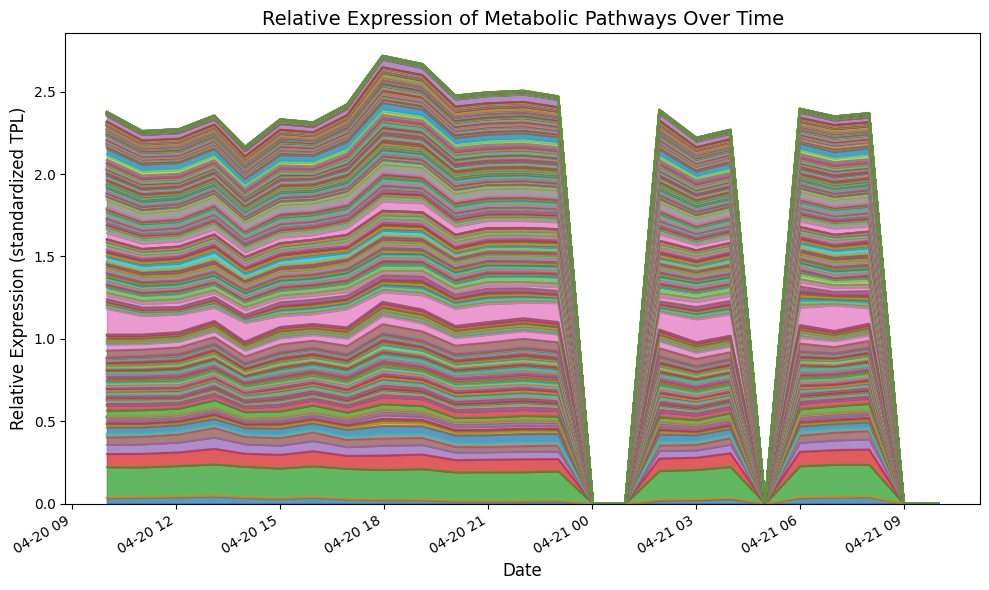

In [192]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Merge module_importance with env_data to include the Date column
module_importance_with_date = module_importance.merge(env_data[['sample', 'Date']], on='sample', how='left')

# Convert the Date column to datetime format for proper plotting
module_importance_with_date['Date'] = pd.to_datetime(module_importance_with_date['Date'])

# Sort the dataframe by Date for better visualization
module_importance_with_date = module_importance_with_date.sort_values(by='Date')
# Replace 0 with NaN in the standardized TPL values to interrupt the line plot
module_importance_with_date.replace(0, np.nan, inplace=True)

# Set the Date as the x-axis and plot the relative expression of each module
module_importance_with_date.set_index('Date', inplace=True)

# Plot a stacked area chart for relative expression
module_importance_with_date.iloc[:, 1:].plot(kind='area', stacked=True, figsize=(10, 6), alpha=0.75)

# Customize the plot for publication
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Relative Expression of Metabolic Pathways Over Time', fontsize=14)
# Remove the legend 
plt.legend().set_visible(False)
plt.tight_layout()

# Save the plot as a publication-ready figure
#plt.savefig('pathway_module_expression_over_time.png', dpi=300)
plt.show()

Pathway map01232 - Nucleotide metabolism not found in the data
Pathway map01250 - Biosynthesis of nucleotide sugars not found in the data
Pathway map01240 - Biosynthesis of cofactors not found in the data
Pathway map01310 - Nitrogen cycle not found in the data


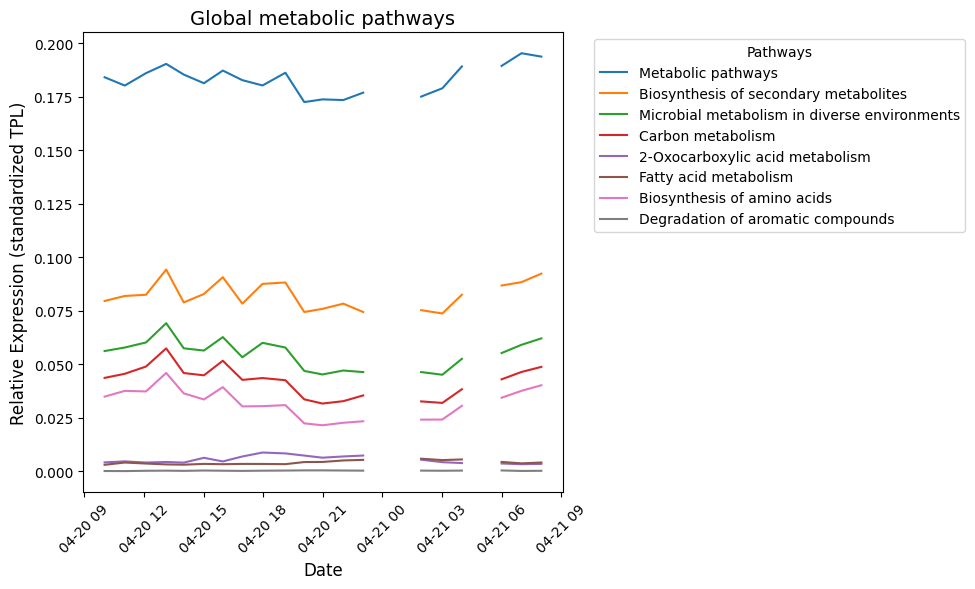

In [193]:
# Just include the global and overview maps
## Dictionary to store the global pathways
global_pathways = {
    "map01100": "Metabolic pathways",
    "map01110": "Biosynthesis of secondary metabolites",
    "map01120": "Microbial metabolism in diverse environments",
    "map01200": "Carbon metabolism",
    "map01210": "2-Oxocarboxylic acid metabolism",
    "map01212": "Fatty acid metabolism",
    "map01230": "Biosynthesis of amino acids",
    "map01232": "Nucleotide metabolism",
    "map01250": "Biosynthesis of nucleotide sugars",
    "map01240": "Biosynthesis of cofactors",
    "map01220": "Degradation of aromatic compounds",
    "map01310": "Nitrogen cycle"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in global_pathways.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Global metabolic pathways', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

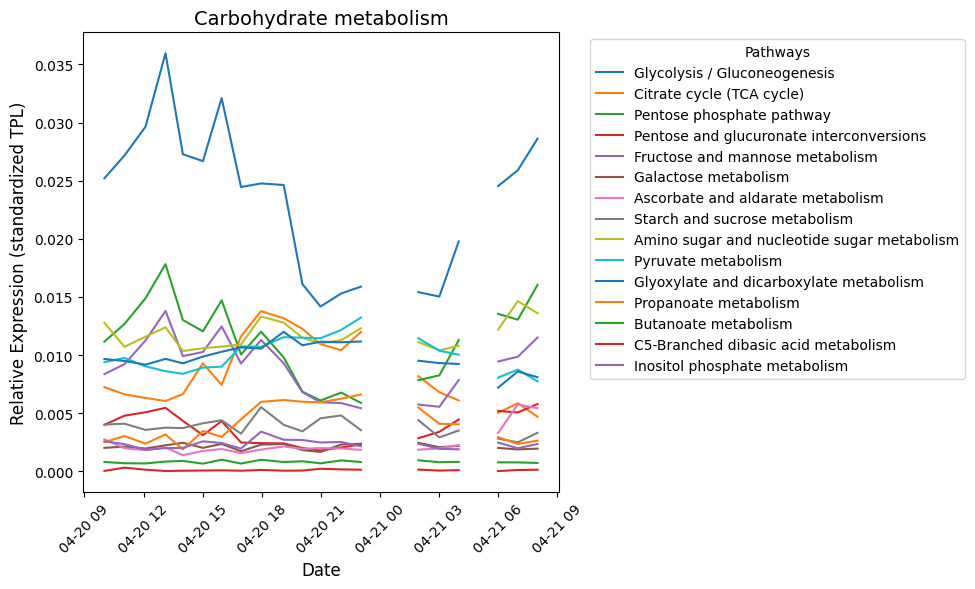

In [194]:
# Carbohydrate metabolism pathways
## Dictionary to store the carbohydrate pathways
carbohydrate_metabolism = {
"map00010": "Glycolysis / Gluconeogenesis",
"map00020": "Citrate cycle (TCA cycle)",
"map00030": "Pentose phosphate pathway",
"map00040": "Pentose and glucuronate interconversions",
"map00051": "Fructose and mannose metabolism",
"map00052": "Galactose metabolism",
"map00053": "Ascorbate and aldarate metabolism",
"map00500": "Starch and sucrose metabolism",
"map00520": "Amino sugar and nucleotide sugar metabolism",
"map00620": "Pyruvate metabolism",
"map00630": "Glyoxylate and dicarboxylate metabolism",
"map00640": "Propanoate metabolism",
"map00650": "Butanoate metabolism",
"map00660": "C5-Branched dibasic acid metabolism",
"map00562": "Inositol phosphate metabolism"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in carbohydrate_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Carbohydrate metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

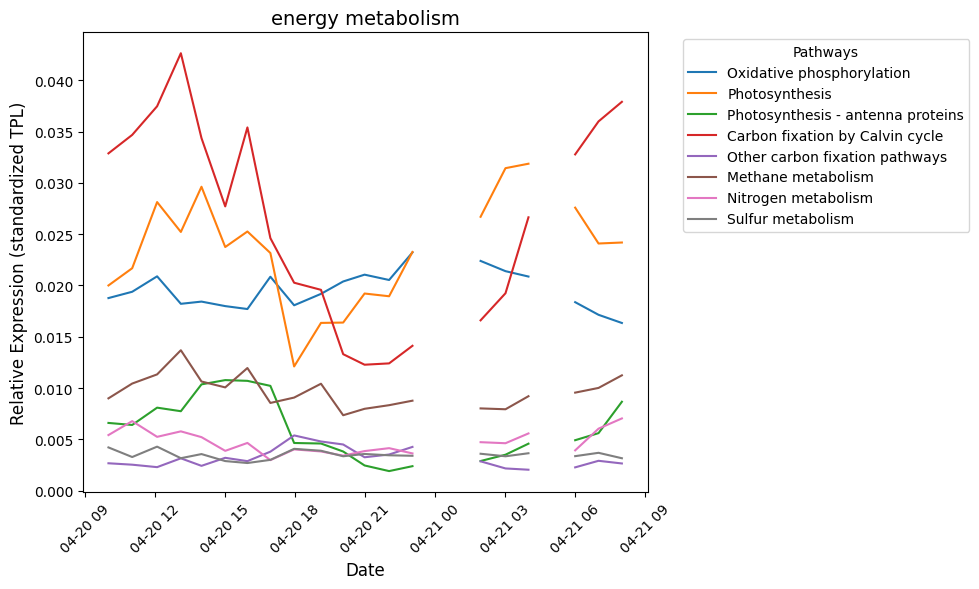

In [149]:
# energy metabolism pathways
## Dictionary to store the energy pathways
energy_metabolism = {
"map00190": "Oxidative phosphorylation", 
"map00195": "Photosynthesis", 
"map00196": "Photosynthesis - antenna proteins", 
"map00710": "Carbon fixation by Calvin cycle", 
"map00720": "Other carbon fixation pathways", 
"map00680": "Methane metabolism", 
"map00910": "Nitrogen metabolism", 
"map00920": "Sulfur metabolism"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in energy_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('energy metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

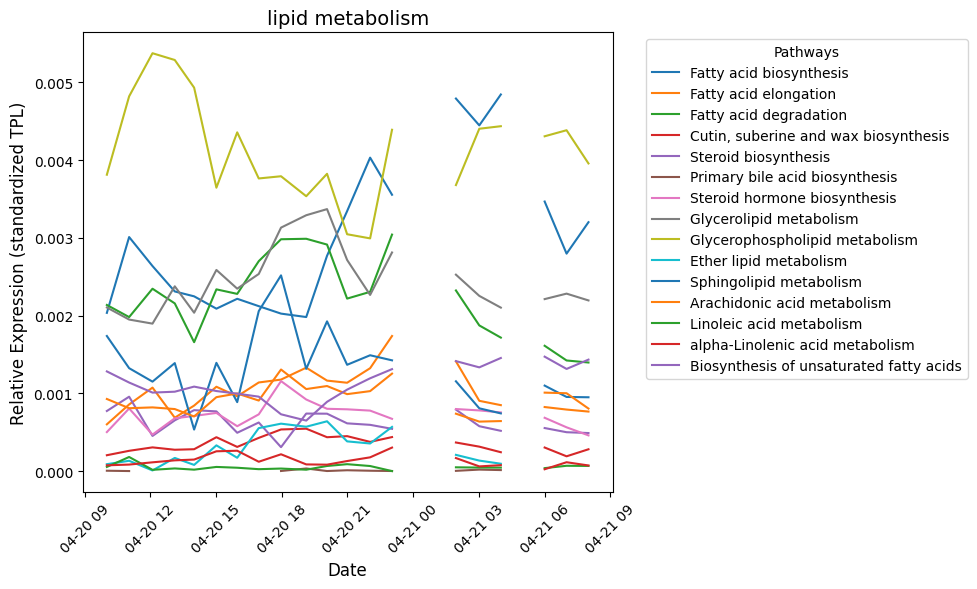

In [152]:
# lipid metabolism pathways
## Dictionary to store the lipid pathways
lipid_metabolism = {
"map00061": "Fatty acid biosynthesis",
"map00062": "Fatty acid elongation",
"map00071": "Fatty acid degradation",
"map00073": "Cutin, suberine and wax biosynthesis",
"map00074": "Mycolic acid biosynthesis New!",
"map00100": "Steroid biosynthesis",
"map00120": "Primary bile acid biosynthesis",
"map00121": "Secondary bile acid biosynthesis",
"map00140": "Steroid hormone biosynthesis",
"map00561": "Glycerolipid metabolism",
"map00564": "Glycerophospholipid metabolism",
"map00565": "Ether lipid metabolism",
"map00600": "Sphingolipid metabolism",
"map00590": "Arachidonic acid metabolism",
"map00591": "Linoleic acid metabolism",
"map00592": "alpha-Linolenic acid metabolism", 
"map01040": "Biosynthesis of unsaturated fatty acids"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in lipid_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('lipid metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



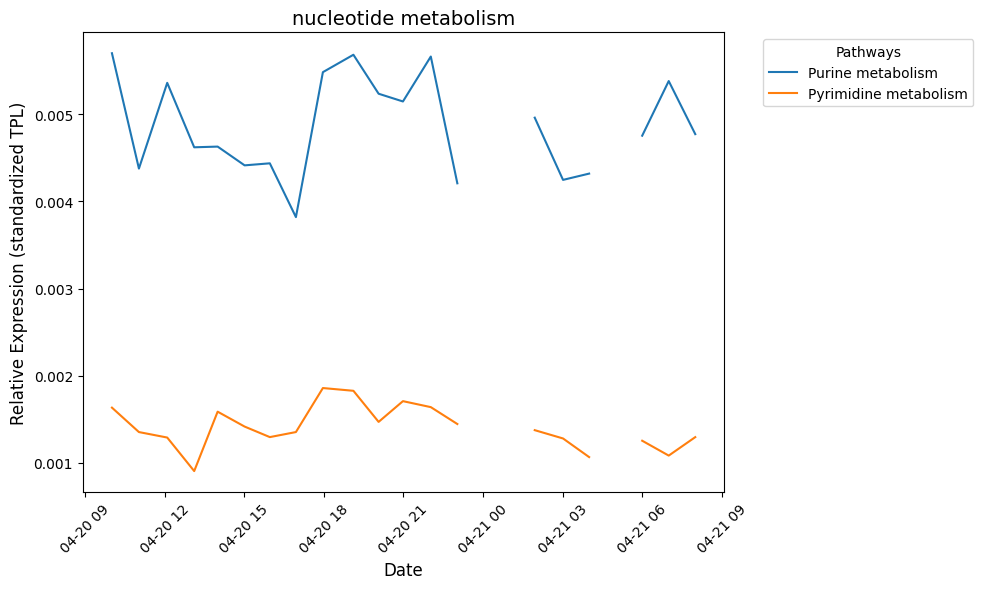

In [153]:
# nucleotide metabolism pathways
## Dictionary to store the nucleotide pathways
nucleotide_metabolism = {
"map00230": "Purine metabolism",
"map00240": "Pyrimidine metabolism"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in nucleotide_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('nucleotide metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



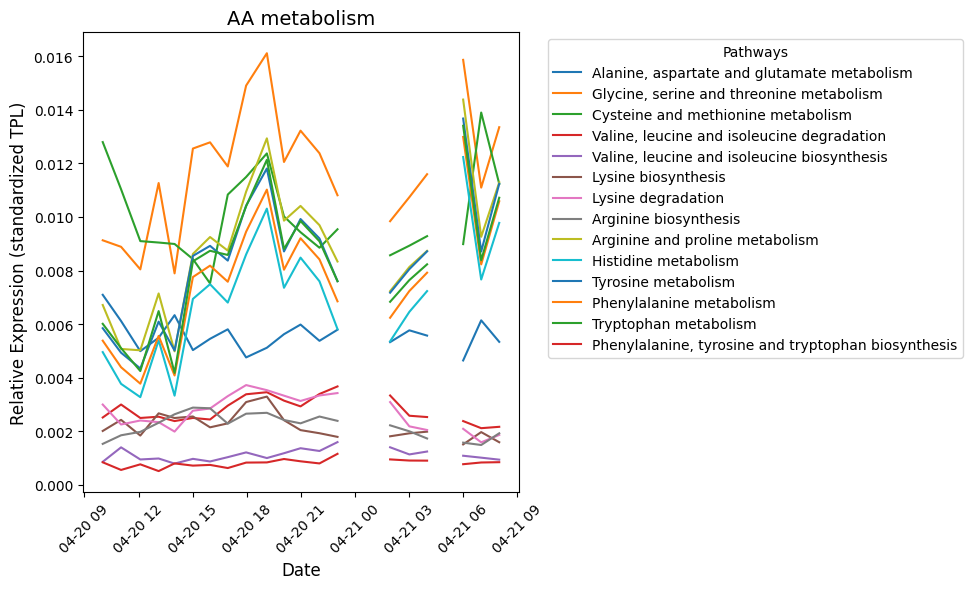

In [154]:
# AA metabolism pathways
## Dictionary to store the AA pathways
AA_metabolism = {
"map00250": "Alanine, aspartate and glutamate metabolism",
"map00260": "Glycine, serine and threonine metabolism",
"map00270": "Cysteine and methionine metabolism",
"map00280": "Valine, leucine and isoleucine degradation",
"map00290": "Valine, leucine and isoleucine biosynthesis",
"map00300": "Lysine biosynthesis",
"map00310": "Lysine degradation",
"map00220": "Arginine biosynthesis",
"map00330": "Arginine and proline metabolism",
"map00340": "Histidine metabolism",
"map00350": "Tyrosine metabolism",
"map00360": "Phenylalanine metabolism",
"map00380": "Tryptophan metabolism",
"map00400": "Phenylalanine, tyrosine and tryptophan biosynthesis"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in AA_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('AA metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



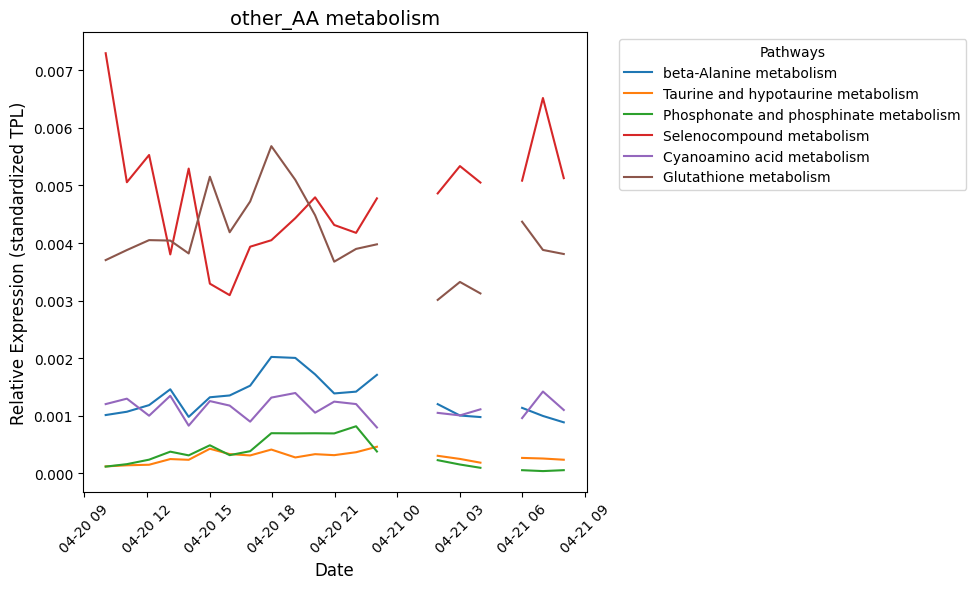

In [155]:
# other_AA metabolism pathways
## Dictionary to store the other_AA pathways
other_AA_metabolism = {
"map00410": "beta-Alanine metabolism", 
"map00430": "Taurine and hypotaurine metabolism", 
"map00440": "Phosphonate and phosphinate metabolism", 
"map00450": "Selenocompound metabolism", 
"map00460": "Cyanoamino acid metabolism", 
"map00470": "D-Amino acid metabolism", 
"map00480": "Glutathione metabolism"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in other_AA_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('other_AA metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



Pathway map00532 - Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate not found in the data
Pathway map00601 - Glycosphingolipid biosynthesis - lacto and neolacto series not found in the data
Pathway map00540 - Lipopolysaccharide biosynthesis not found in the data
Pathway map00542 - O-Antigen repeat unit biosynthesis not found in the data
Pathway map00541 - O-Antigen nucleotide sugar biosynthesis not found in the data
Pathway map00552 - Teichoic acid biosynthesis not found in the data
Pathway map00571 - Lipoarabinomannan (LAM) biosynthesis not found in the data
Pathway map00572 - Arabinogalactan biosynthesis - Mycobacterium not found in the data
Pathway map00543 - Exopolysaccharide biosynthesis not found in the data


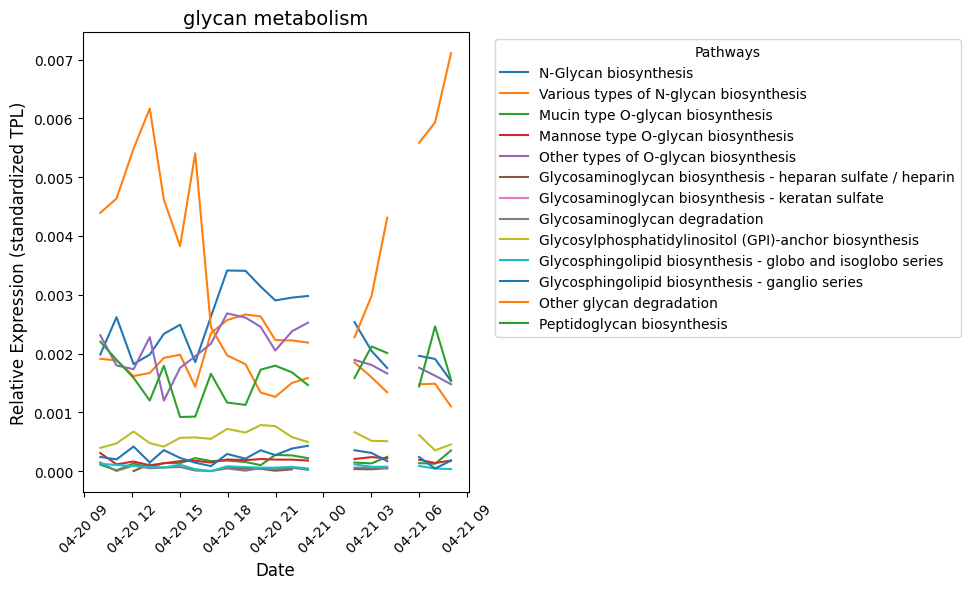

In [158]:
# glycan metabolism pathways
## Dictionary to store the glycan pathways
glycan_metabolism = {
"map00510": "N-Glycan biosynthesis",
"map00513": "Various types of N-glycan biosynthesis",
"map00512": "Mucin type O-glycan biosynthesis",
"map00515": "Mannose type O-glycan biosynthesis",
"map00514": "Other types of O-glycan biosynthesis",
"map00532": "Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate",
"map00534": "Glycosaminoglycan biosynthesis - heparan sulfate / heparin",
"map00533": "Glycosaminoglycan biosynthesis - keratan sulfate",
"map00531": "Glycosaminoglycan degradation",
"map00563": "Glycosylphosphatidylinositol (GPI)-anchor biosynthesis",
"map00601": "Glycosphingolipid biosynthesis - lacto and neolacto series",
"map00603": "Glycosphingolipid biosynthesis - globo and isoglobo series",
"map00604": "Glycosphingolipid biosynthesis - ganglio series",
"map00511": "Other glycan degradation",
"map00540": "Lipopolysaccharide biosynthesis",
"map00542": "O-Antigen repeat unit biosynthesis",
"map00541": "O-Antigen nucleotide sugar biosynthesis",
"map00550": "Peptidoglycan biosynthesis",
"map00552": "Teichoic acid biosynthesis",
"map00571": "Lipoarabinomannan (LAM) biosynthesis",
"map00572": "Arabinogalactan biosynthesis - Mycobacterium",
"map00543": "Exopolysaccharide biosynthesis"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in glycan_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('glycan metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

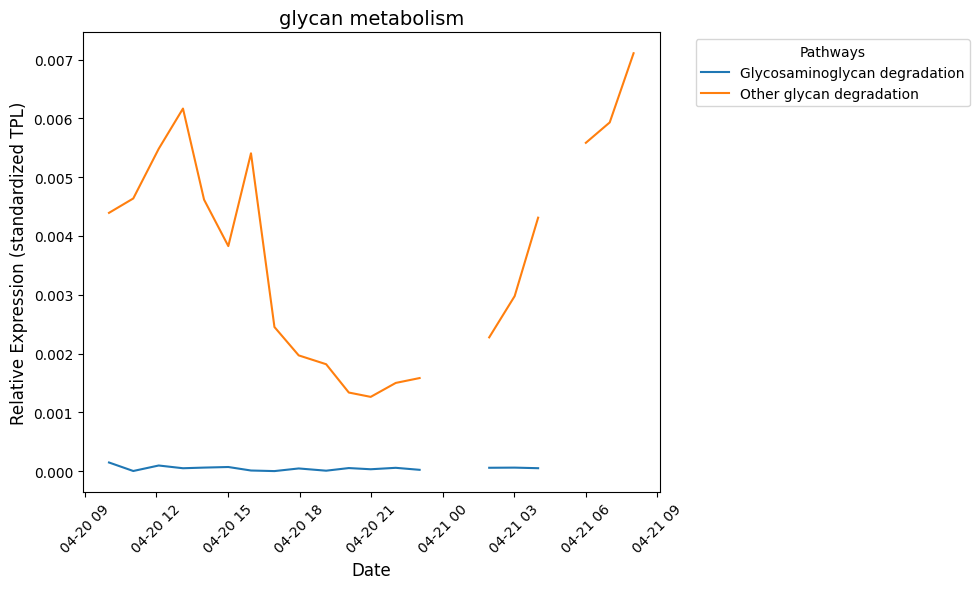

In [161]:
# glycan metabolism pathways
## Dictionary to store the glycan pathways
glycan_metabolism = {
"map00531": "Glycosaminoglycan degradation",
"map00511": "Other glycan degradation",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in glycan_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('glycan metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

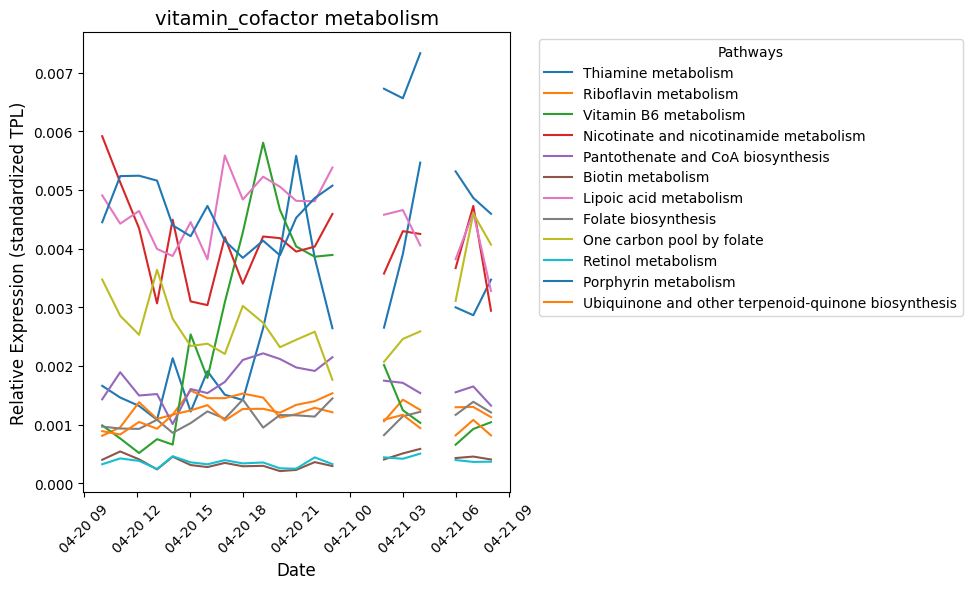

In [162]:
# vitamin_cofactor metabolism pathways
## Dictionary to store the vitamin_cofactor pathways
vitamin_cofactor_metabolism = {
"map00730": "Thiamine metabolism",
"map00740": "Riboflavin metabolism",
"map00750": "Vitamin B6 metabolism",
"map00760": "Nicotinate and nicotinamide metabolism",
"map00770": "Pantothenate and CoA biosynthesis",
"map00780": "Biotin metabolism",
"map00785": "Lipoic acid metabolism",
"map00790": "Folate biosynthesis",
"map00670": "One carbon pool by folate",
"map00830": "Retinol metabolism",
"map00860": "Porphyrin metabolism",
"map00130": "Ubiquinone and other terpenoid-quinone biosynthesis"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in vitamin_cofactor_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('vitamin_cofactor metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map00902 - Monoterpenoid biosynthesis not found in the data
Pathway map00907 - Pinene, camphor and geraniol degradation not found in the data
Pathway map01052 - Type I polyketide structures not found in the data
Pathway map00522 - Biosynthesis of 12-, 14- and 16-membered macrolides not found in the data
Pathway map00253 - Tetracycline biosynthesis not found in the data
Pathway map01054 - Nonribosomal peptide structures not found in the data


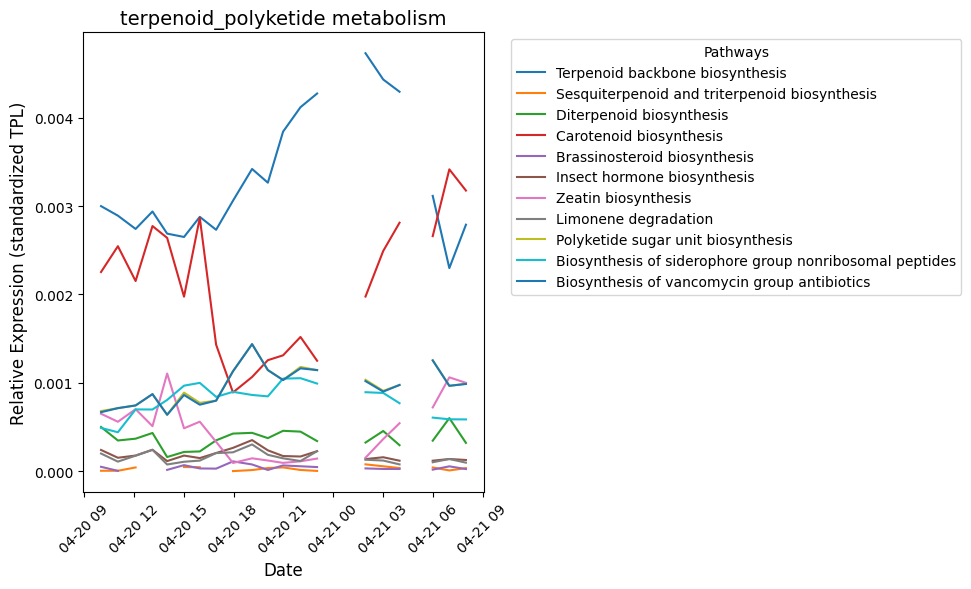

In [163]:
# terpenoid_polyketide metabolism pathways
## Dictionary to store the terpenoid_polyketide pathways
terpenoid_polyketide_metabolism = {
"map00900": "Terpenoid backbone biosynthesis",
"map00902": "Monoterpenoid biosynthesis",
"map00909": "Sesquiterpenoid and triterpenoid biosynthesis",
"map00904": "Diterpenoid biosynthesis",
"map00906": "Carotenoid biosynthesis",
"map00905": "Brassinosteroid biosynthesis",
"map00981": "Insect hormone biosynthesis",
"map00908": "Zeatin biosynthesis",
"map00903": "Limonene degradation",
"map00907": "Pinene, camphor and geraniol degradation",
"map01052": "Type I polyketide structures",
"map00522": "Biosynthesis of 12-, 14- and 16-membered macrolides",
"map00253": "Tetracycline biosynthesis",
"map00523": "Polyketide sugar unit biosynthesis",
"map01054": "Nonribosomal peptide structures",
"map01053": "Biosynthesis of siderophore group nonribosomal peptides",
"map01055": "Biosynthesis of vancomycin group antibiotics"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in terpenoid_polyketide_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('terpenoid_polyketide metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

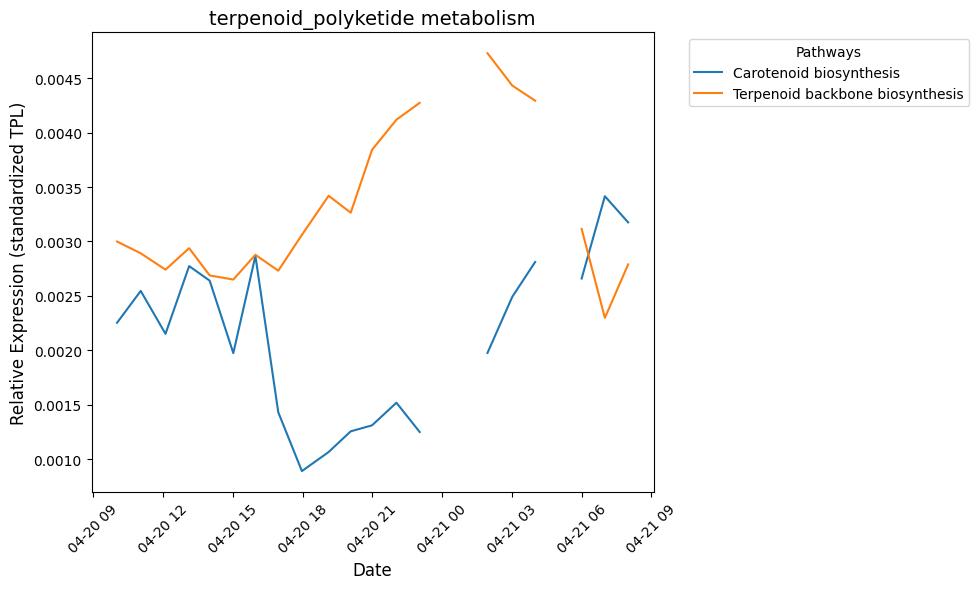

In [166]:
# terpenoid_polyketide metabolism pathways
## Dictionary to store the terpenoid_polyketide pathways
terpenoid_polyketide_metabolism = {
"map00906": "Carotenoid biosynthesis",
"map00900": "Terpenoid backbone biosynthesis",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in terpenoid_polyketide_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('terpenoid_polyketide metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map00942 - Anthocyanin biosynthesis not found in the data
Pathway map00943 - Isoflavonoid biosynthesis not found in the data
Pathway map00946 - Degradation of flavonoids not found in the data
Pathway map00403 - Indole diterpene alkaloid biosynthesis not found in the data
Pathway map00996 - Biosynthesis of various alkaloids not found in the data
Pathway map00232 - Caffeine metabolism not found in the data
Pathway map00966 - Glucosinolate biosynthesis not found in the data
Pathway map00402 - Benzoxazinoid biosynthesis not found in the data
Pathway map00311 - Penicillin and cephalosporin biosynthesis not found in the data
Pathway map00331 - Clavulanic acid biosynthesis not found in the data
Pathway map00404 - Staurosporine biosynthesis not found in the data
Pathway map00405 - Phenazine biosynthesis not found in the data
Pathway map00998 - Biosynthesis of various antibiotics not found in the data
Pathway map00999 - Biosynthesis of various plant secondary metabolites not found in th

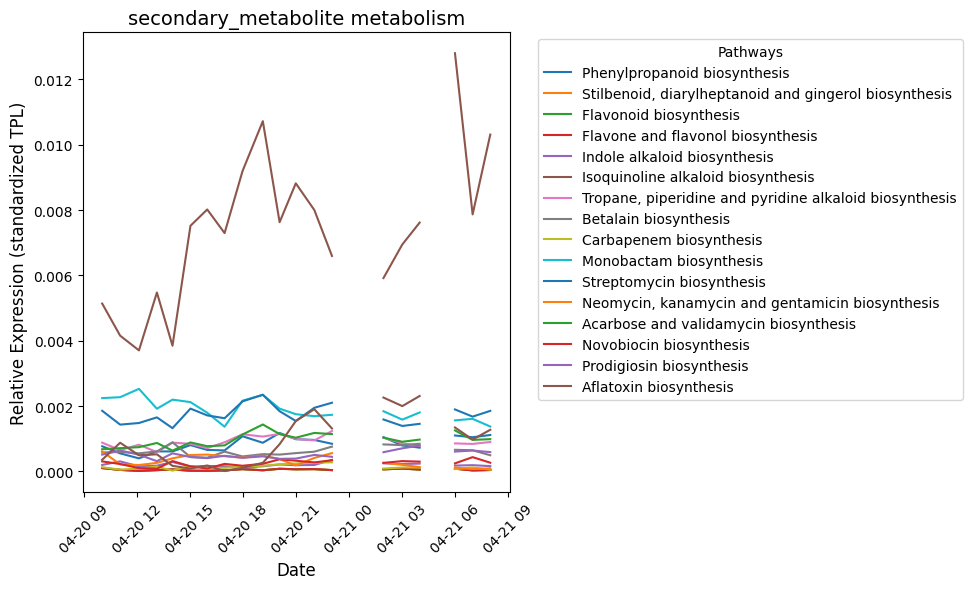

In [167]:
# secondary_metabolite metabolism pathways
## Dictionary to store the secondary_metabolite pathways
secondary_metabolite_metabolism = {
"map00940": "Phenylpropanoid biosynthesis",
"map00945": "Stilbenoid, diarylheptanoid and gingerol biosynthesis",
"map00941": "Flavonoid biosynthesis",
"map00944": "Flavone and flavonol biosynthesis",
"map00942": "Anthocyanin biosynthesis",
"map00943": "Isoflavonoid biosynthesis",
"map00946": "Degradation of flavonoids",
"map00901": "Indole alkaloid biosynthesis",
"map00403": "Indole diterpene alkaloid biosynthesis",
"map00950": "Isoquinoline alkaloid biosynthesis",
"map00960": "Tropane, piperidine and pyridine alkaloid biosynthesis",
"map00996": "Biosynthesis of various alkaloids",
"map00232": "Caffeine metabolism",
"map00965": "Betalain biosynthesis",
"map00966": "Glucosinolate biosynthesis",
"map00402": "Benzoxazinoid biosynthesis",
"map00311": "Penicillin and cephalosporin biosynthesis",
"map00332": "Carbapenem biosynthesis",
"map00261": "Monobactam biosynthesis",
"map00331": "Clavulanic acid biosynthesis",
"map00521": "Streptomycin biosynthesis",
"map00524": "Neomycin, kanamycin and gentamicin biosynthesis",
"map00525": "Acarbose and validamycin biosynthesis",
"map00401": "Novobiocin biosynthesis",
"map00404": "Staurosporine biosynthesis",
"map00405": "Phenazine biosynthesis",
"map00333": "Prodigiosin biosynthesis",
"map00254": "Aflatoxin biosynthesis",
"map00998": "Biosynthesis of various antibiotics",
"map00999": "Biosynthesis of various plant secondary metabolites",
"map00997": "Biosynthesis of various other secondary metabolites"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in secondary_metabolite_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('secondary_metabolite metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

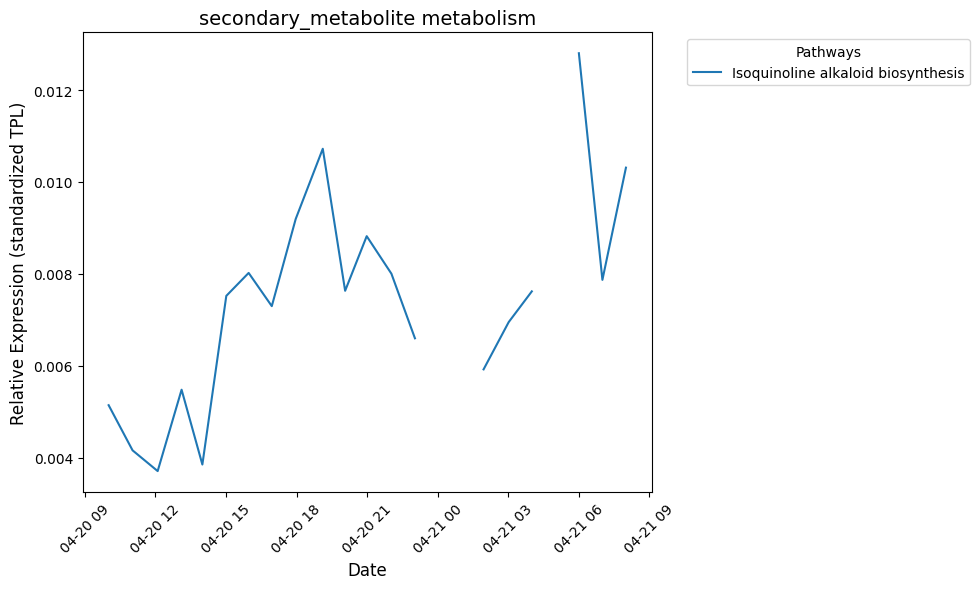

In [169]:
# secondary_metabolite metabolism pathways
## Dictionary to store the secondary_metabolite pathways
secondary_metabolite_metabolism = {
"map00950": "Isoquinoline alkaloid biosynthesis",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in secondary_metabolite_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('secondary_metabolite metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map00622 - Xylene degradation not found in the data
Pathway map00633 - Nitrotoluene degradation not found in the data
Pathway map00642 - Ethylbenzene degradation not found in the data
Pathway map00791 - Atrazine degradation not found in the data
Pathway map00363 - Bisphenol degradation not found in the data
Pathway map00365 - Furfural degradation not found in the data
Pathway map00984 - Steroid degradation not found in the data


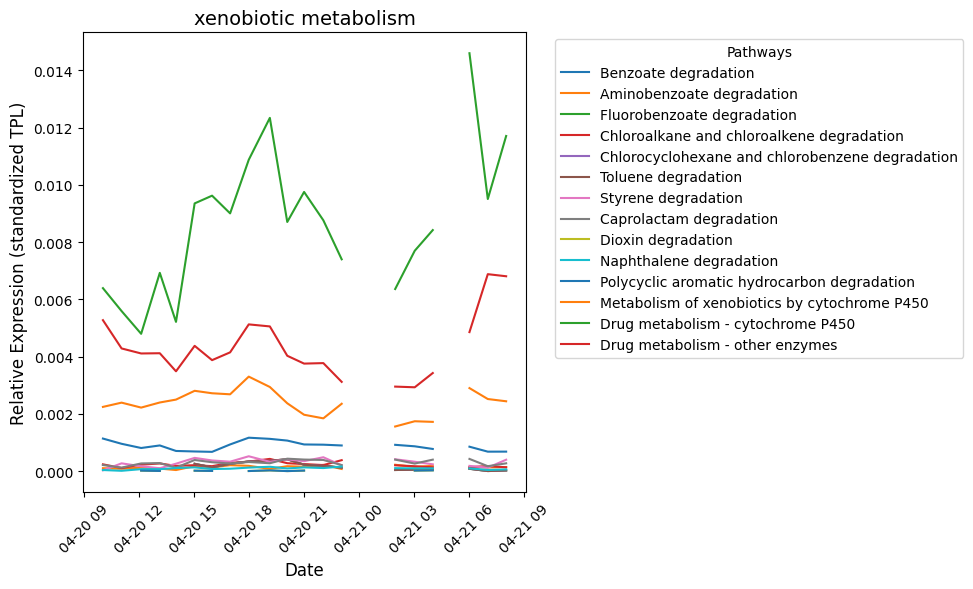

In [171]:
# xenobiotic metabolism pathways
## Dictionary to store the xenobiotic pathways
xenobiotic_metabolism = {
"map00362": "Benzoate degradation", 
"map00627": "Aminobenzoate degradation", 
"map00364": "Fluorobenzoate degradation", 
"map00625": "Chloroalkane and chloroalkene degradation", 
"map00361": "Chlorocyclohexane and chlorobenzene degradation", 
"map00623": "Toluene degradation", 
"map00622": "Xylene degradation", 
"map00633": "Nitrotoluene degradation", 
"map00642": "Ethylbenzene degradation", 
"map00643": "Styrene degradation", 
"map00791": "Atrazine degradation", 
"map00930": "Caprolactam degradation", 
"map00363": "Bisphenol degradation", 
"map00621": "Dioxin degradation", 
"map00626": "Naphthalene degradation", 
"map00624": "Polycyclic aromatic hydrocarbon degradation", 
"map00365": "Furfural degradation", 
"map00984": "Steroid degradation", 
"map00980": "Metabolism of xenobiotics by cytochrome P450", 
"map00982": "Drug metabolism - cytochrome P450", 
"map00983": "Drug metabolism - other enzymes"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in xenobiotic_metabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('xenobiotic metabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

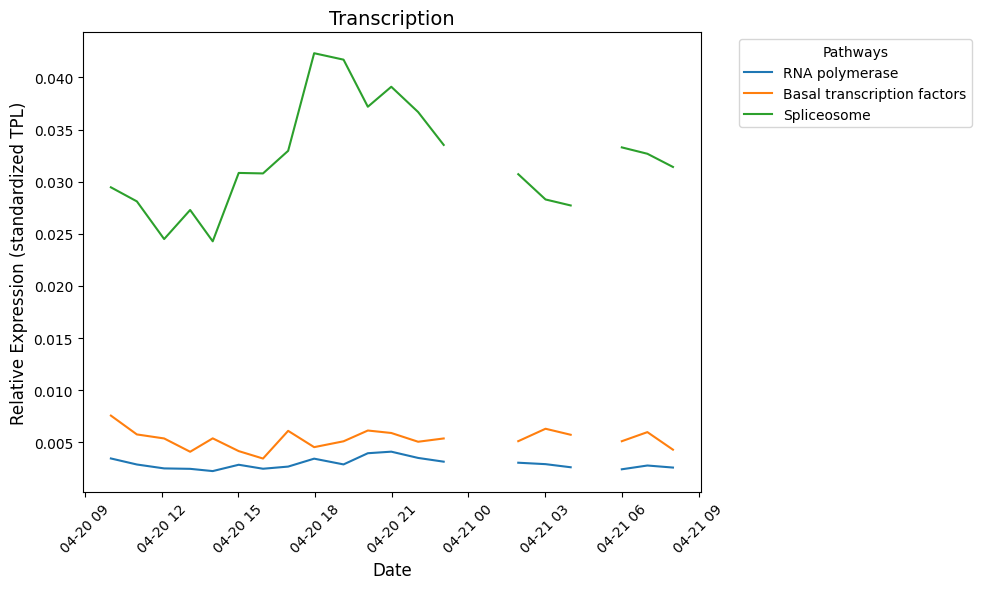

In [173]:
# transcription pathways
## Dictionary to store the xenobiotic pathways
transcription = {
"map03020": 'RNA polymerase',
"map03022": 'Basal transcription factors',
"map03040": 'Spliceosome',
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in transcription.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Transcription', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

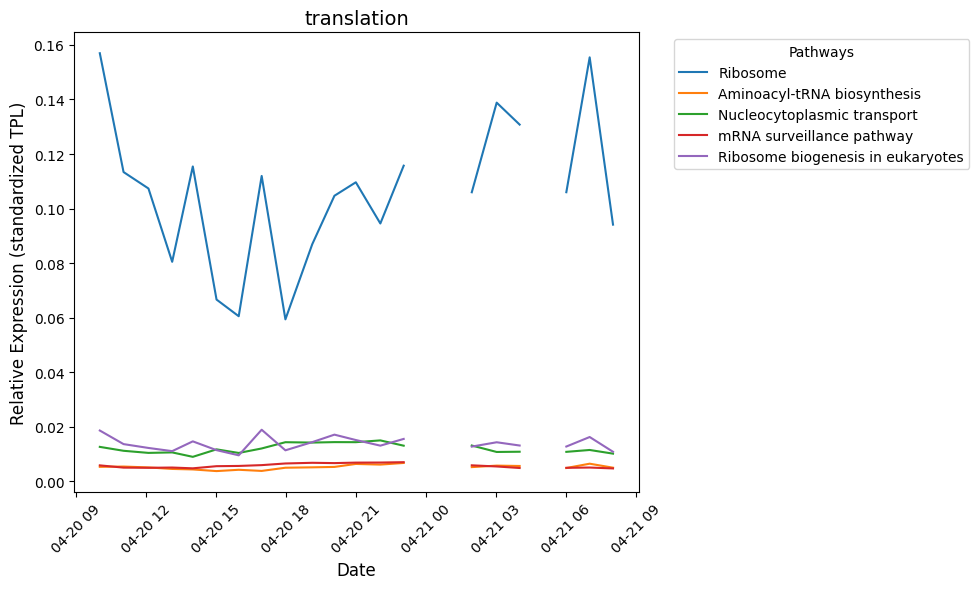

In [174]:
# translation pathways
## Dictionary to store the xenobiotic pathways
translation = {
"map03010": 'Ribosome',
"map00970": "Aminoacyl-tRNA biosynthesis",
"map03013": "Nucleocytoplasmic transport", 
"map03015": "mRNA surveillance pathway", 
"map03008": "Ribosome biogenesis in eukaryotes", 
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in translation.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('translation', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

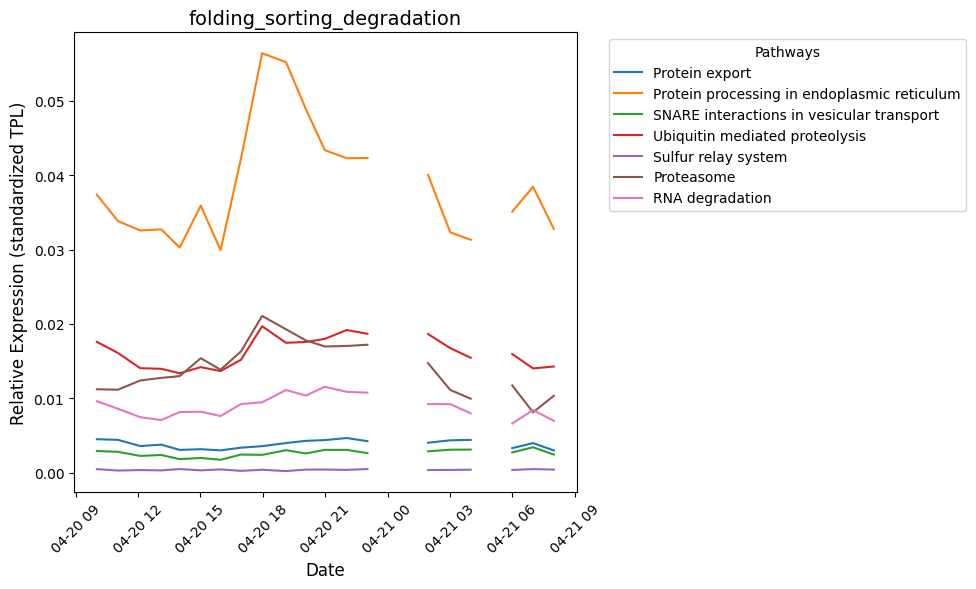

In [176]:
# folding_sorting_degradation pathways
## Dictionary to store the xenobiotic pathways
folding_sorting_degradation = {
"map03060": "Protein export",
"map04141": "Protein processing in endoplasmic reticulum",
"map04130": "SNARE interactions in vesicular transport",
"map04120": "Ubiquitin mediated proteolysis",
"map04122": "Sulfur relay system",
"map03050": "Proteasome",
"map03018": "RNA degradation"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in folding_sorting_degradation.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('folding_sorting_degradation', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

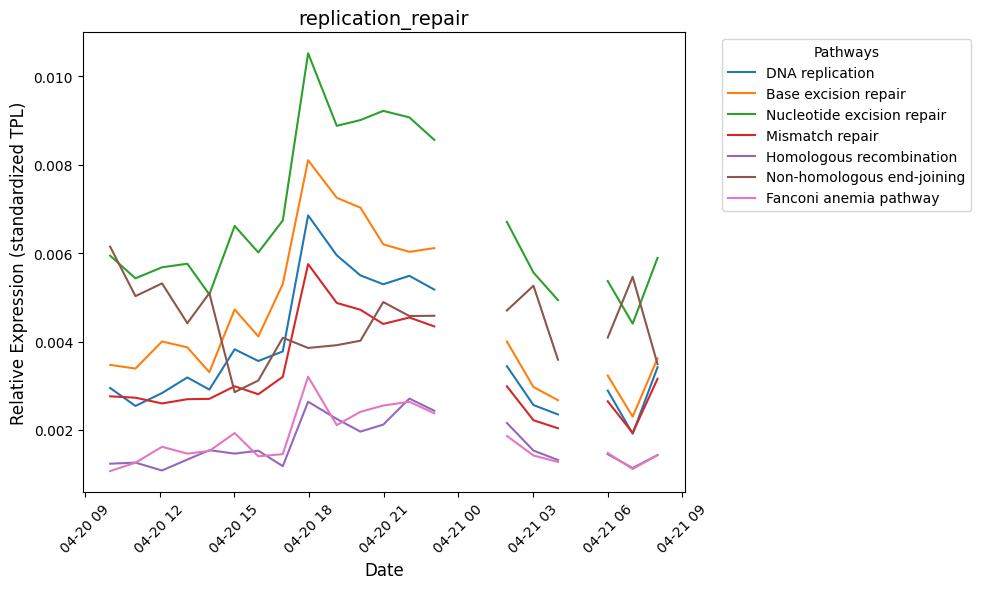

In [177]:
# replication_repair pathways
## Dictionary to store the xenobiotic pathways
replication_repair = {
"map03030": "DNA replication",
"map03410": "Base excision repair",
"map03420": "Nucleotide excision repair",
"map03430": "Mismatch repair",
"map03440": "Homologous recombination",
"map03450": "Non-homologous end-joining",
"map03460": "Fanconi anemia pathway",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in replication_repair.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('replication_repair', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map02060 - Phosphotransferase system (PTS) not found in the data


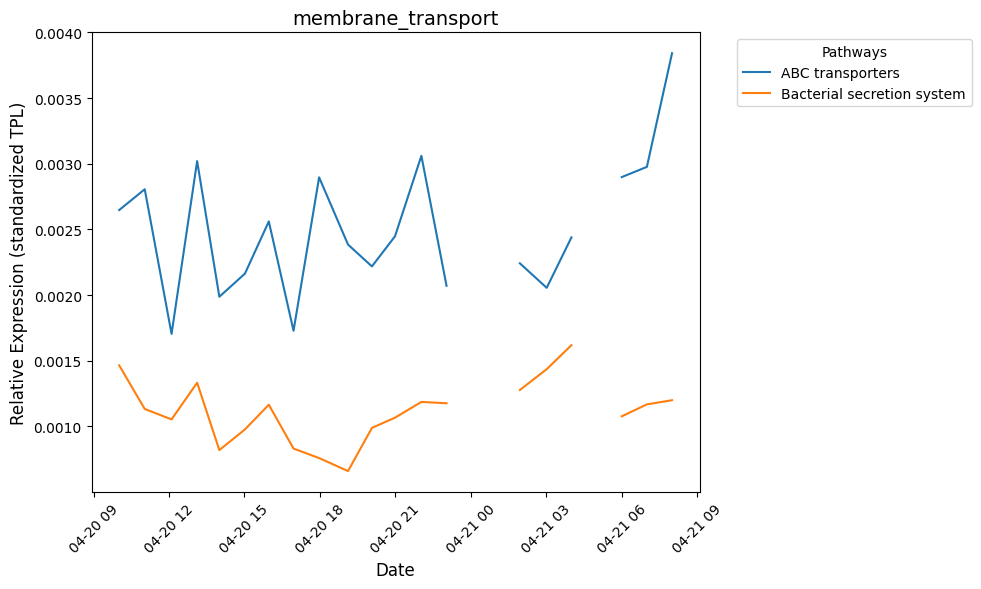

In [178]:
# membrane_transport pathways
## Dictionary to store the xenobiotic pathways
membrane_transport = {
"map02010": "ABC transporters",
"map02060": "Phosphotransferase system (PTS)",
"map03070": "Bacterial secretion system"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in membrane_transport.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('membrane_transport', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

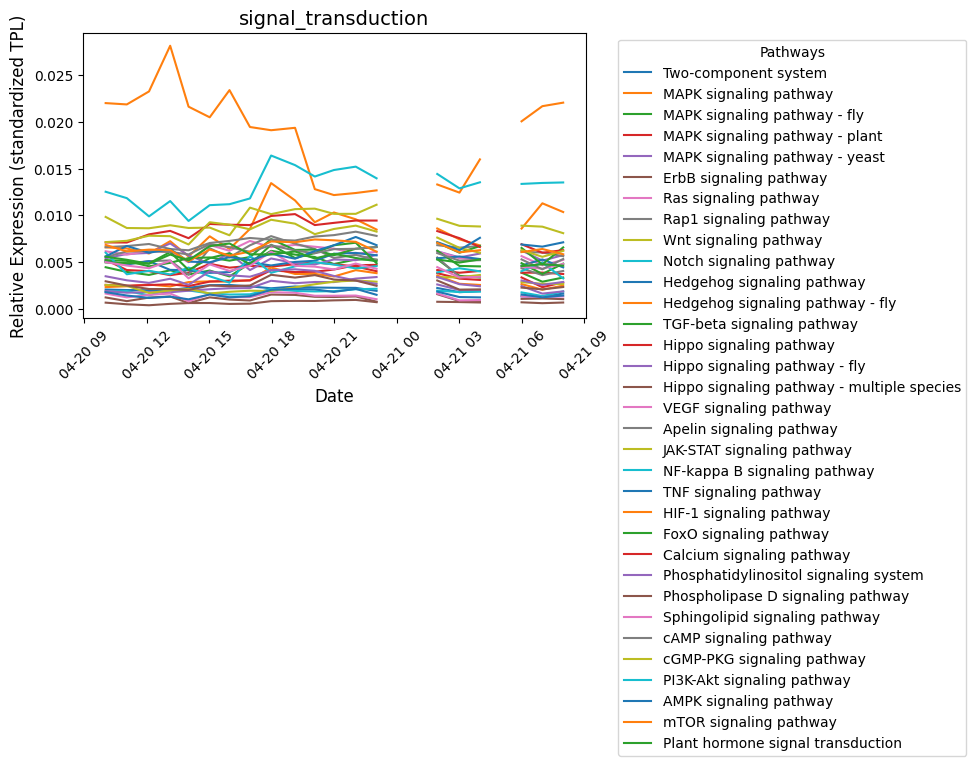

In [179]:
# signal_transduction pathways
## Dictionary to store the xenobiotic pathways
signal_transduction = {
"map02020": "Two-component system", 
"map04010": "MAPK signaling pathway", 
"map04013": "MAPK signaling pathway - fly", 
"map04016": "MAPK signaling pathway - plant", 
"map04011": "MAPK signaling pathway - yeast", 
"map04012": "ErbB signaling pathway", 
"map04014": "Ras signaling pathway", 
"map04015": "Rap1 signaling pathway", 
"map04310": "Wnt signaling pathway", 
"map04330": "Notch signaling pathway", 
"map04340": "Hedgehog signaling pathway", 
"map04341": "Hedgehog signaling pathway - fly", 
"map04350": "TGF-beta signaling pathway", 
"map04390": "Hippo signaling pathway", 
"map04391": "Hippo signaling pathway - fly", 
"map04392": "Hippo signaling pathway - multiple species", 
"map04370": "VEGF signaling pathway", 
"map04371": "Apelin signaling pathway", 
"map04630": "JAK-STAT signaling pathway", 
"map04064": "NF-kappa B signaling pathway", 
"map04668": "TNF signaling pathway", 
"map04066": "HIF-1 signaling pathway", 
"map04068": "FoxO signaling pathway", 
"map04020": "Calcium signaling pathway", 
"map04070": "Phosphatidylinositol signaling system", 
"map04072": "Phospholipase D signaling pathway", 
"map04071": "Sphingolipid signaling pathway", 
"map04024": "cAMP signaling pathway", 
"map04022": "cGMP-PKG signaling pathway", 
"map04151": "PI3K-Akt signaling pathway", 
"map04152": "AMPK signaling pathway", 
"map04150": "mTOR signaling pathway", 
"map04075": "Plant hormone signal transduction"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in signal_transduction.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('signal_transduction', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map04061 - Viral protein interaction with cytokine and cytokine receptor not found in the data


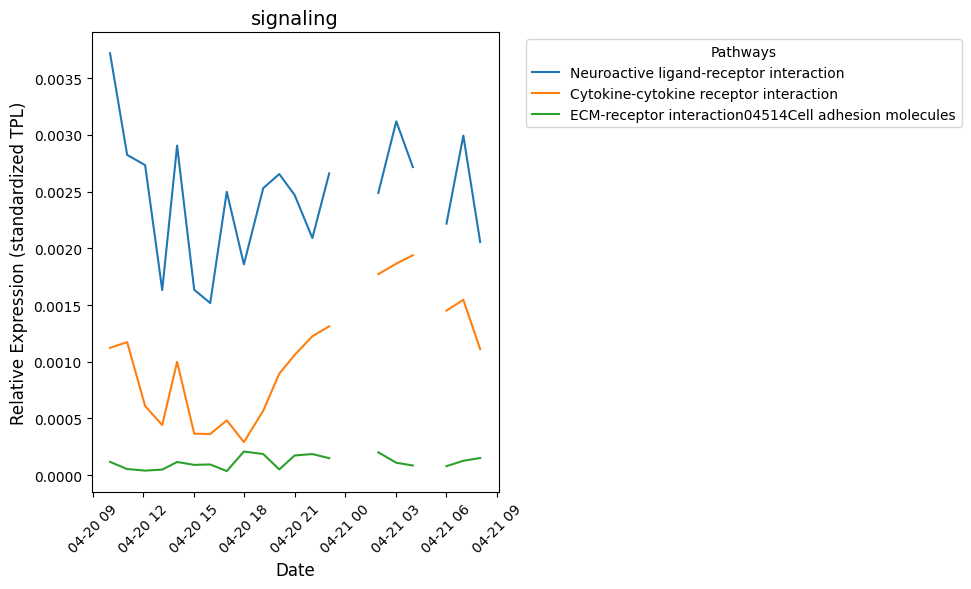

In [180]:
# signaling pathways
## Dictionary to store the xenobiotic pathways
signaling = {
"map04080": "Neuroactive ligand-receptor interaction",
"map04060": "Cytokine-cytokine receptor interaction",
"map04061": "Viral protein interaction with cytokine and cytokine receptor",
"map04512": "ECM-receptor interaction04514Cell adhesion molecules",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in signaling.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('signaling', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map04148 - Efferocytosis not found in the data


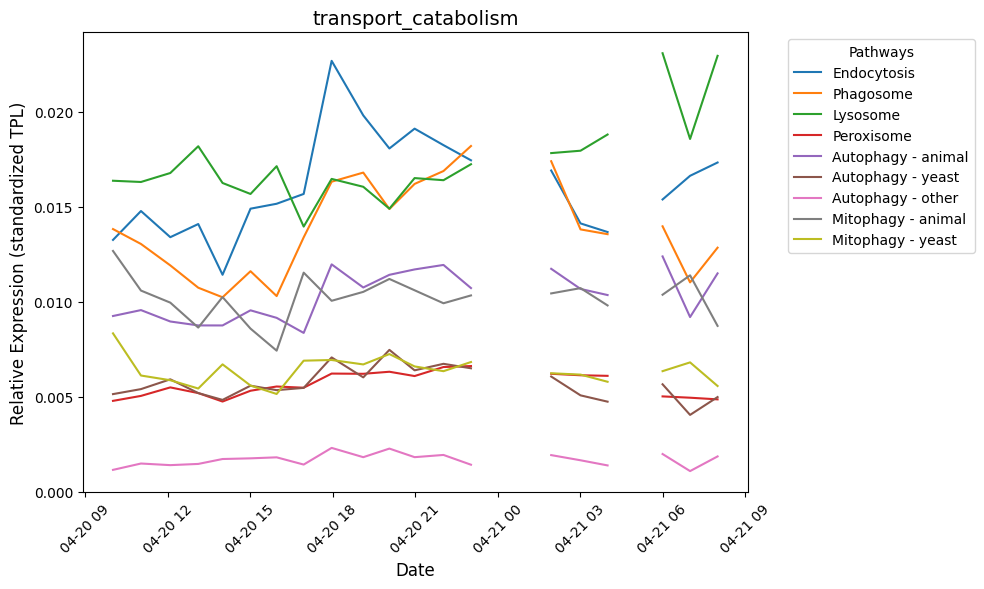

In [181]:
# transport_catabolism pathways
## Dictionary to store the xenobiotic pathways
transport_catabolism = {
"map04144": "Endocytosis", 
"map04145": "Phagosome", 
"map04142": "Lysosome", 
"map04146": "Peroxisome", 
"map04140": "Autophagy - animal", 
"map04138": "Autophagy - yeast", 
"map04136": "Autophagy - other", 
"map04137": "Mitophagy - animal", 
"map04139": "Mitophagy - yeast", 
"map04148": "Efferocytosis"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in transport_catabolism.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('transport_catabolism', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

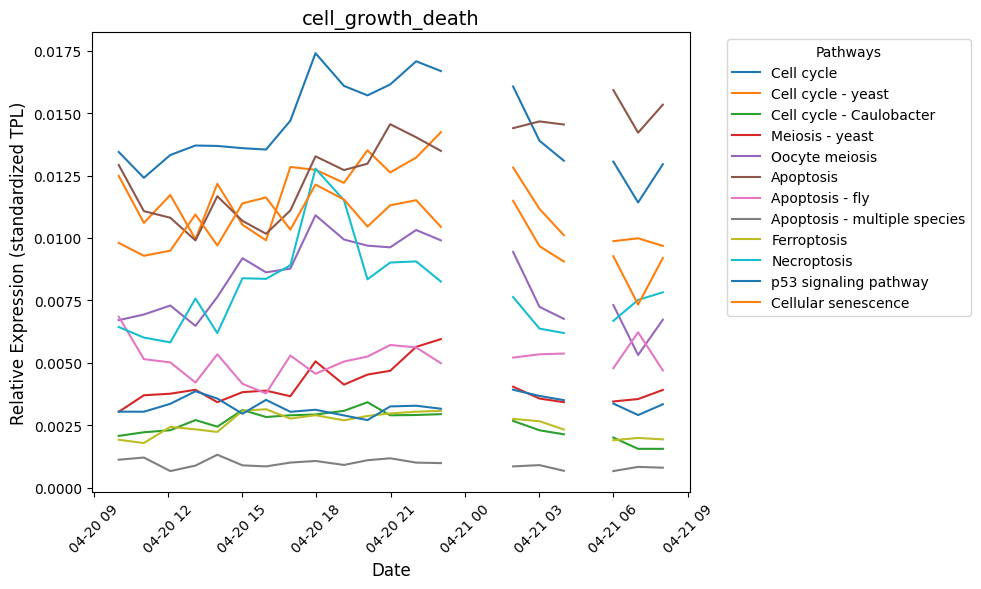

In [182]:
# cell_growth_death pathways
## Dictionary to store the xenobiotic pathways
cell_growth_death = {
"map04110": "Cell cycle",
"map04111": "Cell cycle - yeast",
"map04112": "Cell cycle - Caulobacter",
"map04113": "Meiosis - yeast",
"map04114": "Oocyte meiosis",
"map04210": "Apoptosis",
"map04214": "Apoptosis - fly",
"map04215": "Apoptosis - multiple species",
"map04216": "Ferroptosis",
"map04217": "Necroptosis",
"map04115": "p53 signaling pathway",
"map04218": "Cellular senescence",
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in cell_growth_death.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('cell_growth_death', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

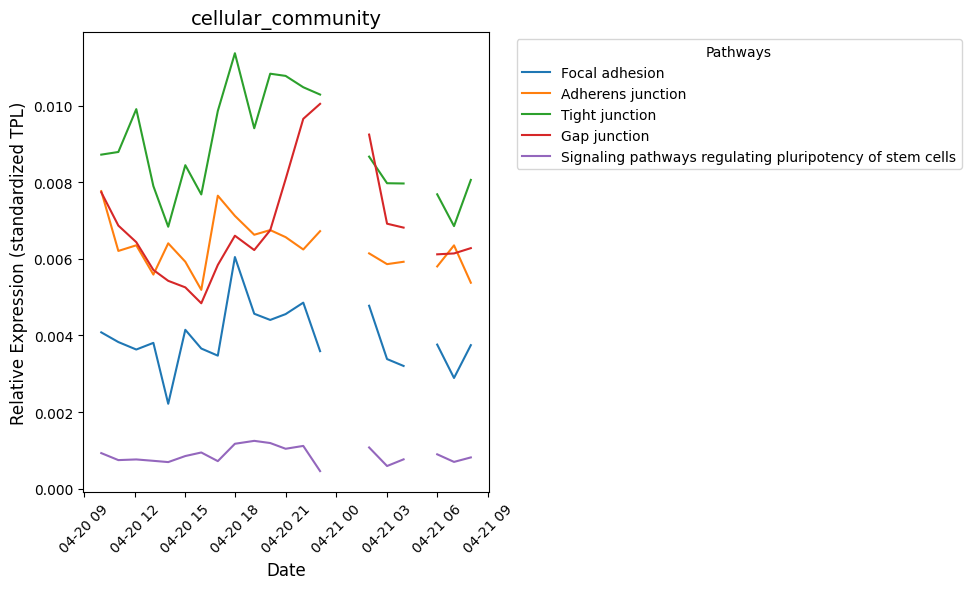

In [183]:
# cellular_community pathways
## Dictionary to store the xenobiotic pathways
cellular_community = {
"map04510": "Focal adhesion", 
"map04520": "Adherens junction", 
"map04530": "Tight junction", 
"map04540": "Gap junction", 
"map04550": "Signaling pathways regulating pluripotency of stem cells", 
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in cellular_community.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('cellular_community', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Pathway map02040 - Flagellar assembly not found in the data
Pathway map04814 - Motor proteins not found in the data


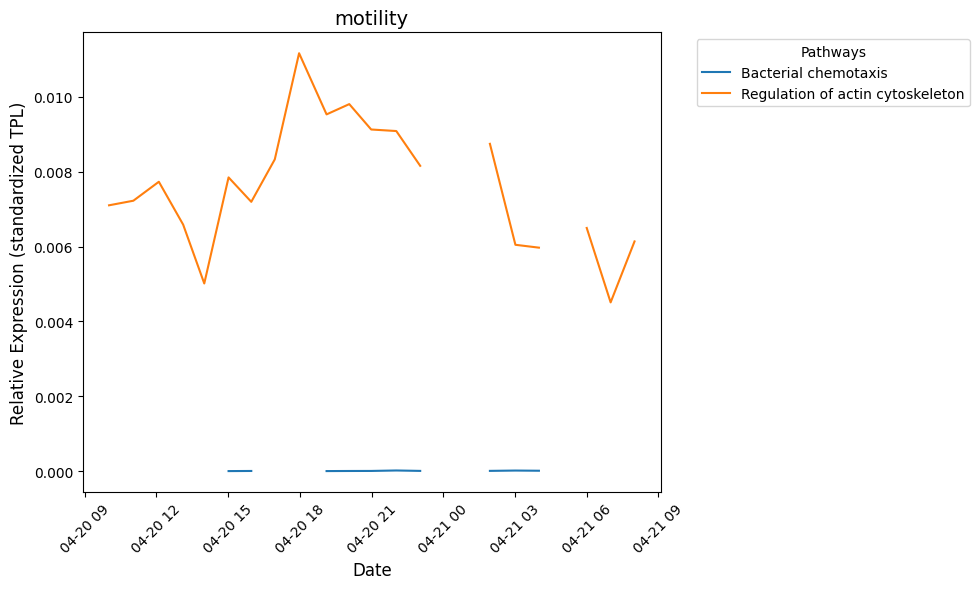

In [184]:
# motility pathways
## Dictionary to store the xenobiotic pathways
motility = {
"map02030": "Bacterial chemotaxis", 
"map02040": "Flagellar assembly", 
"map04814": "Motor proteins", 
"map04810": "Regulation of actin cytoskeleton"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in motility.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('motility', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

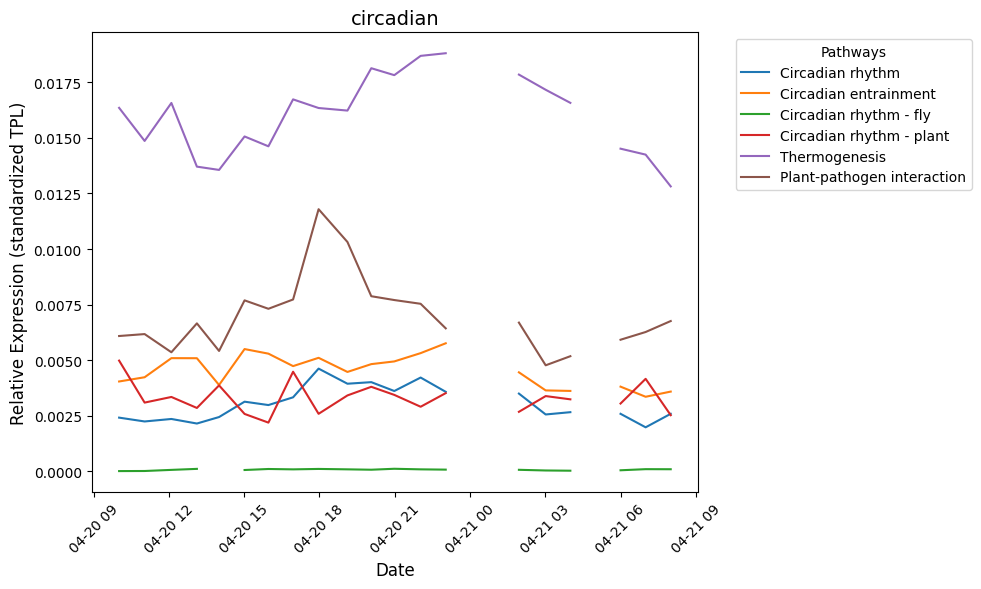

In [185]:
# circadian pathways
## Dictionary to store the xenobiotic pathways
circadian = {
"map04710": "Circadian rhythm",
"map04713": "Circadian entrainment",
"map04711": "Circadian rhythm - fly",
"map04712": "Circadian rhythm - plant",
"map04714": "Thermogenesis",
"map04626": "Plant-pathogen interaction"
}

# Plot the top 10 pathways with the most variance over time
plt.figure(figsize=(10, 6))

# Loop over each pathway and plot it
for pathway, name in circadian.items():
    if pathway in module_importance_with_date.columns:
        plt.plot(module_importance_with_date.index, module_importance_with_date[pathway], label=name)
    else:
        print(f"Pathway {pathway} - {name} not found in the data")

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('circadian', fontsize=14)
plt.legend(title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## GO Terms

In [99]:
# Step 1: Remove the 'GO:' prefix and split multiple GO terms
data['GO_terms_clean'] = data['GOs'].str.split(',')

# Step 2: Explode the dataframe to have one GO term per row (duplicating TPL values accordingly)
data_exploded_go = data.explode('GO_terms_clean')

# Dictionary to store biological process GO terms and associated transcripts
go_bp_module = {}

# Loop over GO terms and populate the dictionary
for go_term in data_exploded_go['GO_terms_clean'].unique():
    go_data = data_exploded_go[data_exploded_go['GO_terms_clean'] == go_term]
    
    # Store the cleaned data in the dictionary
    go_bp_module[go_term] = go_data

# Initialize a dataframe to hold the relative importance of each GO term per sample
go_importance = pd.DataFrame()

# Iterate through each GO term and sum the TPL_standardized values for the corresponding GO terms
for go_term, go_data in go_bp_module.items():
    # Sum the standardized TPL for each sample for the given GO term
    go_sums = go_data.groupby('sample')['TPL_standardized'].sum().reset_index()
    
    # Rename the columns for clarity
    go_sums.columns = ['sample', f'{go_term}']
    
    # Merge with the main go_importance dataframe
    if go_importance.empty:
        go_importance = go_sums
    else:
        go_importance = go_importance.merge(go_sums, on='sample', how='outer')

# Merge go_importance with env_data to include the Date column
go_importance_with_date = go_importance.merge(env_data[['sample', 'Date']], on='sample', how='left')

# Convert the Date column to datetime format
go_importance_with_date['Date'] = pd.to_datetime(go_importance_with_date['Date'])

# Sort the dataframe by Date for better visualization
go_importance_with_date = go_importance_with_date.sort_values(by='Date')

# Set the Date as the index for plotting
go_importance_with_date.set_index('Date', inplace=True)

# Plot the top 10 GO terms with the most variance over time (similar to KEGG)
variance_go_df = go_importance_with_date.drop(columns=['sample']).var()
top_10_var_go = variance_go_df.sort_values(ascending=False).head(10)
top_10_go_terms = top_10_var_go.index.tolist()

# Plot the top 10 GO biological process terms
plt.figure(figsize=(10, 6))
for go_term in top_10_go_terms:
    plt.plot(go_importance_with_date.index, go_importance_with_date[go_term], label=go_term, marker='o')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Top 10 Biological Process GO Terms with the Most Variance Across Samples', fontsize=14)
plt.legend(title='GO Terms', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

KeyError: 'GOs'

## Modules

In [107]:
# Step 1: Remove any potential prefixes and split multiple modules
data['KEGG_Module_clean'] = data['KEGG_Module'].str.split(',')

# Step 2: Explode the dataframe to have one module per row (duplicating TPL values accordingly)
data_exploded_module = data.explode('KEGG_Module_clean')

# Inspect the cleaned and exploded KEGG Module data
data_exploded_module.head()

Description  TPL_standardized
6                                                     -          1.400871
5041                 structural constituent of ribosome          0.942804
872                     Chlorophyll A-B binding protein          0.579722
2306                             PPP5 TPR repeat region          0.331988
4506       peptidyl-prolyl cis-trans isomerase activity          0.258131
4746  protein localization to cytosolic proteasome c...          0.221881
1418  Ferredoxins are iron-sulfur proteins that tran...          0.185199
4469                            oxidoreductase activity          0.160122
174                                         ATP binding          0.158920
5220                           unfolded protein binding          0.135009

In [ ]:
# Dictionary to store KEGG Modules and associated transcripts
module_dict = {}

# Loop over unique modules and populate the dictionary
for module in data_exploded_module['KEGG_Module_clean'].unique():
    module_data = data_exploded_module[data_exploded_module['KEGG_Module_clean'] == module]
    
    # Store the cleaned data in the dictionary
    module_dict[module] = module_data


In [ ]:
# Initialize a dataframe to hold the relative importance of each module per sample
kegg_module_importance = pd.DataFrame()

# Iterate through each module and sum the TPL_standardized values for the corresponding KEGG modules
for module, module_data in module_dict.items():
    # Sum the standardized TPL for each sample for the given module
    module_sums = module_data.groupby('sample')['TPL_standardized'].sum().reset_index()
    
    # Rename the columns for clarity
    module_sums.columns = ['sample', f'{module}']
    
    # Merge with the main kegg_module_importance dataframe
    if kegg_module_importance.empty:
        kegg_module_importance = module_sums
    else:
        kegg_module_importance = kegg_module_importance.merge(module_sums, on='sample', how='outer')


In [ ]:
# Merge kegg_module_importance with env_data to include the Date column
kegg_module_importance_with_date = kegg_module_importance.merge(env_data[['sample', 'Date']], on='sample', how='left')

# Convert the Date column to datetime format
kegg_module_importance_with_date['Date'] = pd.to_datetime(kegg_module_importance_with_date['Date'])

# Sort the dataframe by Date for better visualization
kegg_module_importance_with_date = kegg_module_importance_with_date.sort_values(by='Date')

# Set the Date as the index for plotting
kegg_module_importance_with_date.set_index('Date', inplace=True)

# Plot the top 10 KEGG modules with the most variance over time
variance_module_df = kegg_module_importance_with_date.drop(columns=['sample']).var()
top_10_var_modules = variance_module_df.sort_values(ascending=False).head(10)
top_10_modules = top_10_var_modules.index.tolist()

# Plot the top 10 KEGG modules
plt.figure(figsize=(10, 6))
for module in top_10_modules:
    plt.plot(kegg_module_importance_with_date.index, kegg_module_importance_with_date[module], label=module, marker='o')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Relative Expression (standardized TPL)', fontsize=12)
plt.title('Top 10 KEGG Modules with the Most Variance Across Samples', fontsize=14)
plt.legend(title='KEGG Modules', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
